In [1]:
from pandas import read_csv

#Load data set
look_back = 2
series_influ_A_df = read_csv('../data/vietnam_flu_A_month.csv', engine='python')
# series_influ_A_df = series_influ_A_df[["Day","Influenza A - All types of surveillance"]]

df = series_influ_A_df.rename(columns= {"Influenza A - All types of surveillance": "case"})
df = df[(df['Month'] >='2011-04-01') & (df['Month'] <='2020-02-01')]

In [2]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Month'], y=df['case'], mode='lines+markers', name=f'Influenza A Cases in month'))
fig.update_layout(
    title='abc',
    xaxis=dict(
        title='Month',
        tickvals=df['Month'],  
        tickformat='%Y-%m',
        tickangle=90,
    ),
    yaxis=dict(title='Number of Cases'),
    showlegend=True,
)

# Show plot
fig.show()

In [3]:
import numpy as np
# def create_dataset(dataset, look_back=2, num_predict=1):
#     dataX, dataY = [], []
#     for i in range(0, len(dataset)-2 *look_back+1, look_back - num_predict):
#         a = dataset[i:(i+look_back)]
#         dataX.append(a)
#         dataY.append(dataset[i + look_back - num_predict : i+ 2*look_back-num_predict])
#     return np.array(dataX), np.array(dataY)

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [145]:
num_predict = 5
# length = len(df) - len(df) % num_predict
# adf = df[:length]
# adf = adf["case"]
# adf = df["case"]

import pandas as pd

def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()
ma_df = df[["Month", "case"]]
# Áp dụng Moving Average Filter
window_size = 3  # Bạn có thể điều chỉnh kích thước cửa sổ tùy ý
ma_df['case_ma'] = moving_average(ma_df['case'], window_size)
ma_df = ma_df.dropna()
adf = pd.DataFrame()
adf["case"] = ma_df["case_ma"]

In [171]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
scaler = MinMaxScaler()
#process data

look_back = 12
dataset = adf.astype('float32')
dataset = dataset.values

flattened_dataset = dataset.flatten()
dataset = scaler.fit_transform(flattened_dataset.reshape(-1,1))
dataset = dataset.reshape(dataset.shape)

test_size = num_predict * 2
train = dataset[: -test_size,:]
test = dataset[-test_size - look_back:,:]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [180]:
# i = 86
# print(trainX[i], trainY[i])
# len(trainX)
# j=0
# print(testX[j], testY[j])
import tensorflow as tf
from keras.losses import mean_squared_error
def custom_loss(y_true, y_pred):
    return tf.sqrt(mean_squared_error(y_true, y_pred)/2)

In [185]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, TimeDistributed, Input, Dropout, GRU,concatenate
from sklearn.model_selection import GridSearchCV
from keras.saving import register_keras_serializable
from sklearn.metrics import r2_score

# def build_model(input_shape, dropout=None, dense_units = [], unit=64, optimizer='adam'):
#     input = Input(shape=input_shape)
#     # LSTM Model
#     lstm_model = Sequential([
#         LSTM(64),
#         Dense(activation='relu', units=16)
#     ])
#     lstm_model1 = Sequential([
#         LSTM(32),
#         Dense(activation='relu', units=16)
#     ])

#     # GRU Model
#     gru_model = Sequential([
#         # Input(input_shape=input_shape),
#         GRU(32),
#         Dense(activation='relu', units=16)
#     ])
#     # gru_model1 = Sequential([
#     #     # Input(input_shape=input_shape),
#     #     GRU(64),
#     #     Dense(activation='relu', units=16)
#     # ])

#     lstm_output = lstm_model(input)
#     lstm_output1 = lstm_model1(input)
#     gru_output = gru_model(input)
#     # gru_output1 = gru_model1(input)

#     combined_output = concatenate([lstm_output, gru_output, lstm_output1])

#     dense_layers = Sequential([
#     Dense(units=input_shape[1], activation='sigmoid' )
#     ])

#     final_output = dense_layers(combined_output)
#     model = tf.keras.Model(inputs=input, outputs=final_output)
#     model.compile(optimizer=optimizer, loss=custom_loss, metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model

def build_model(input_shape, dropout=None, dense_units = [], unit=64, optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units=unit, activation='relu'))
    # model.add(LSTM(units=32, activation='relu'))
    model.add(Dense(units=input_shape[1], activation='sigmoid' ))
    model.compile(optimizer=optimizer, loss=custom_loss, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


In [186]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import os
model = build_model(input_shape=(trainX.shape[1], trainX.shape[2]), dense_units=[32,16,8], unit=128)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
file_path = os.path.join('../model', 'test.keras')

mc = ModelCheckpoint(file_path, monitor='loss', mode='min', verbose=1, save_best_only=True)

model.fit(trainX, trainY,batch_size=1, callbacks=[es, mc], verbose=0, epochs=200)


Epoch 1: loss improved from inf to 0.14893, saving model to ../model\test.keras

Epoch 2: loss improved from 0.14893 to 0.10896, saving model to ../model\test.keras

Epoch 3: loss improved from 0.10896 to 0.10056, saving model to ../model\test.keras

Epoch 4: loss did not improve from 0.10056

Epoch 5: loss improved from 0.10056 to 0.09610, saving model to ../model\test.keras

Epoch 6: loss improved from 0.09610 to 0.09250, saving model to ../model\test.keras

Epoch 7: loss improved from 0.09250 to 0.07588, saving model to ../model\test.keras

Epoch 8: loss improved from 0.07588 to 0.07061, saving model to ../model\test.keras

Epoch 9: loss improved from 0.07061 to 0.06070, saving model to ../model\test.keras

Epoch 10: loss improved from 0.06070 to 0.05974, saving model to ../model\test.keras

Epoch 11: loss improved from 0.05974 to 0.05353, saving model to ../model\test.keras

Epoch 12: loss did not improve from 0.05353

Epoch 13: loss did not improve from 0.05353

Epoch 14: loss di

In [20]:
def forecast(input, model):
    input = input.reshape(1, input.shape[0], input.shape[1])
    predicted = model.predict(input, verbose=0)
    return predicted[0]

def make_forecasts(test, model):
    forecasts = []
    inputStart = test[0]
    inputX = inputStart.reshape(1, inputStart.shape[0], inputStart.shape[1])
    for i in range(len(test)):
        predicted = forecast(inputX[i], model)
        forecasts.append(predicted)
        inputXContinue = np.vstack((inputX[-1][1:], predicted))
        inputX = np.append(inputX, [inputXContinue], axis=0)
    
    return forecasts
def evaluate_forecasts(test, forecasts):
    from sklearn.metrics import mean_squared_error
    testScore = np.sqrt(mean_squared_error(test, forecasts))
    print('Test Score: %.2f RMSE' % (testScore))

In [95]:
testY.shape

(10, 1)

In [187]:
forecasts = make_forecasts(testX, model)
# invert predictions
forecasts = scaler.inverse_transform(forecasts)
testY_ = scaler.inverse_transform(testY)
evaluate_forecasts(testY_[:,0].reshape(-1), forecasts[:, 0].reshape(-1))

Test Score: 9.66 RMSE


In [10]:
def plot(testY, forecasts):
    import matplotlib.pyplot as plt
    forecastsPlot = np.empty([forecasts.shape[0]])
    forecastsPlot[:] = np.nan
    forecastsPlot[:] = forecasts[:,0].reshape(-1)
    testPlot = np.empty([testY.shape[0]])
    testPlot[:] = np.nan
    testPlot[:] = testY[:,0].reshape(-1)
    plt.plot(testPlot, "-y", label="actual", marker= '.')
    plt.plot(forecastsPlot, color = 'green', label="forecast", marker='x')
    plt.ylabel("Number of infections")
    plt.legend(["actual", "forecast"])
    plt.show()

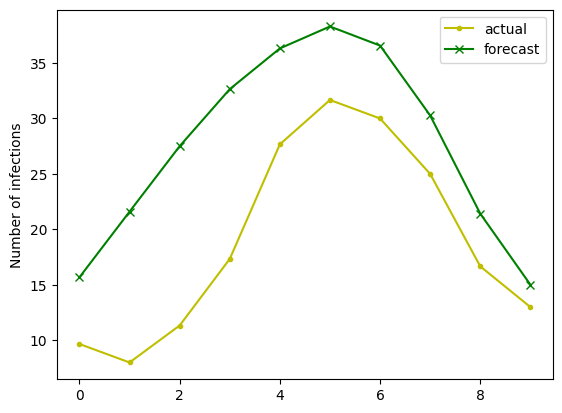

In [188]:
plot(testY_, forecasts)

In [135]:
print(trainX[-1], trainY[-1])
print(testX[0])

[[0.15822785]
 [0.15189874]
 [0.10126583]
 [0.15189874]
 [0.37974685]
 [0.27215192]
 [0.07594937]
 [0.01898734]
 [0.03164557]
 [0.05696203]] [0.10126583]
[[0.15189874]
 [0.10126583]
 [0.15189874]
 [0.37974685]
 [0.27215192]
 [0.07594937]
 [0.01898734]
 [0.03164557]
 [0.05696203]
 [0.10126583]]


In [118]:
testY_.shape

(10, 1)

In [25]:
adf[-test_size:].head(20)

,case
114,24.5
115,20.0
116,20.0
117,42.0
118,51.5
119,27.5
120,7.5
121,4.0
122,7.0
123,12.5


In [189]:
r2 = r2_score(testY_.flatten(), forecasts.flatten())
r2

-0.3261544675331478

In [26]:

import pandas as pd

def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()
ma_df = df[["Month", "case"]]
# Áp dụng Moving Average Filter
window_size = 3  # Bạn có thể điều chỉnh kích thước cửa sổ tùy ý
ma_df['case_ma'] = moving_average(ma_df['case'], window_size)
ma_df = ma_df.dropna()
# ma_df['case_ma'].plot()

fig = go.Figure()
fig.add_trace(go.Scatter(x=ma_df['Month'], y=ma_df['case_ma'], mode='lines+markers', name=f'Influenza A Cases in month'))
fig.update_layout(
    title='abc',
    xaxis=dict(
        title='Month',
        tickvals=ma_df['Month'],  
        tickformat='%Y-%m',
        tickangle=90,
    ),
    yaxis=dict(title='Number of Cases'),
    showlegend=True,
)

# Show plot
fig.show()


<Axes: >

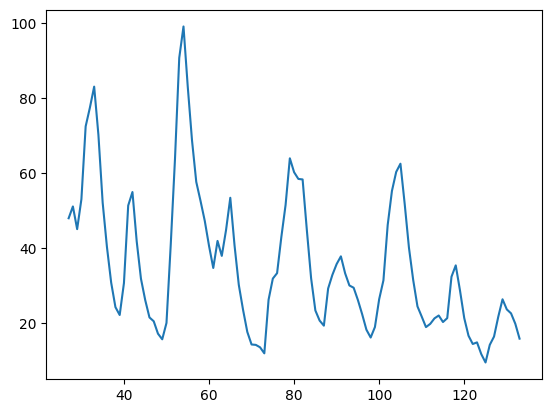

In [29]:
def exponential_moving_average(data, span):
    return data.ewm(span=span, adjust=False).mean()
ema_df = df[["Month", "case"]]

# Áp dụng Exponential Moving Average
span = 6  # Bạn có thể điều chỉnh độ dài span tùy ý
ema_df['case_ema'] = exponential_moving_average(ema_df['case'], span)

ema_df['case_ema'].plot()